In [1]:
import sys
sys.path.insert(0, '/Users/user/Documents/ecg_research/')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.externals import joblib as jl
from savvyecg import ecg_utils
%matplotlib inline


In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import wfdb as wf
import scipy.signal as ss
from sklearn.externals import joblib as jl
from biosppy.signals import ecg as ecgsig
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import peakutils as pu
from scipy.interpolate import interp1d
from sklearn.metrics import confusion_matrix as cf
from imblearn.over_sampling import SMOTE

In [6]:
path = "/Users/user/www.physionet.org/physiobank/database/apnea-ecg/"
records = "RECORDS"
patients_arr = np.array(['a01','a02','a03','a04','a05','a06','a07','a08','a20', 'a19', 'a18', 'a10',\
                         'a11','a12', 'a13', 'a15', 'a16', 'c01', 'c02', 'c03', 'c04', 'c05','c06',\
                            'c07','c08','c09','c10', 'b01', 'b03', 'b04'])


# Load Data

In [7]:
f = 100 #Hz
window = 60 #s

In [8]:
ecg_list, label_list, index_list, RRint_list, rpeaks_list = [] ,[], [], [], []
apnea_patients = {}
for i in patients_arr:
    patient = i
    print (patient)
    sig, fld = wf.rdsamp(path + i)
    apn_all = wf.rdann(path + i, 'apn')
    ecg_temp = sig[:,0] #ecg
    ecg_corr = ecg_utils.baseline_correct(ecg_temp, f) #subtract baseline from ecg
    idx_temp = apn_all[0][:-1] #exclude last index
    label_temp = apn_all[1][:-1] #exclude last label
    ecg_corr[np.where(ecg_corr < 0.01)] = 0
    windowed_temp = np.array([ecg_corr[i : i + window * f] for i in idx_temp]) #window ecg per minute
    rpeaks_temp = np.array([ecgsig.hamilton_segmenter(j, sampling_rate = 100)['rpeaks'] for j in windowed_temp]) #rpeaks
    rrint_temp = np.array([np.diff(i) for i in rpeaks_temp])
    ecg_list.append(windowed_temp)
    label_list.append(label_temp)
    index_list.append(idx_temp)
    rpeaks_list.append(rpeaks_temp)
    RRint_list.append(rrint_temp)
#     window_list.append(windowed_temp)
    apnea_patients[str(patient)] = ecg_temp
    
    

a01
a02
a03
a04
a05
a06
a07
a08
a20
a19
a18
a10
a11
a12
a13
a15
a16
c01
c02
c03
c04
c05
c06
c07
c08
c09
c10
b01
b03
b04


# Remove segments with ugly ECG signals (signals without Rpeaks)

In [9]:
ecgs = np.concatenate(ecg_list)
labels = np.concatenate(label_list)
idxs = np.concatenate(index_list)
RR_int = np.concatenate(RRint_list)
rpeaks_idxs = np.concatenate(rpeaks_list)
peak_count = np.array([len(i) for i in rpeaks_idxs])
#remove segments without any peaks
n_peaks = 30
ecgs = ecgs[np.where(peak_count > n_peaks)]
labels = labels[np.where(peak_count > n_peaks)]
idxs = idxs[np.where(peak_count > n_peaks)]
RR_int = RR_int[np.where(peak_count > n_peaks)]
rpeaks_idxs = rpeaks_idxs[np.where(peak_count > n_peaks)]
peak_count_nz = peak_count[np.where(peak_count > n_peaks)]


In [10]:
ecgs.shape

(14540, 6000)

In [19]:
# apnea_dict = {'ECG':ecgs, 'Indices':idxs, 'Labels':labels, 'RR int': RR_int, 'Rpeak Indices': rpeaks_idxs, 'Peak Count': peak_count_nz}
# jl.dump(apnea_dict, '../ecg_research/Databases/Apnea_database.pickle')

# Calculate Features

In [19]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
#     import matplotlib.pyplot as plt
#     import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(3.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[2.5,2.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([3.5,3.5],[-0.5,2.5], '-k', lw=2)
    
#     ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)
    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pred Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(0,3,
            'Sensitivity: %.2f'%(tp*1./(tp+fn)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(1,3,
            'Specificity: %.2f'%(tn*1./(fp+tn)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

def EDR_all(ecgs, rpeaks_idxs, peak_count_nz):
    EDR_list = []
    for i in range(rpeaks_idxs.shape[0]):
        
        cs_rpeak = interp1d(rpeaks_idxs[i], ecgs[i][rpeaks_idxs[i]])
        min_x = np.min(rpeaks_idxs[i])
        max_x = np.max(rpeaks_idxs[i])
        n = np.max(peak_count_nz)
        t = np.linspace(min_x, max_x, n)
        edr_ = cs_rpeak(t)
        edr_ -= np.mean(edr_) #center the signal
        #edr_, _ = edr(ecgs[i], rpeaks_idxs[i])
        EDR_list.append(edr_)
    EDR = np.array(EDR_list)
    return EDR
def iqr(x):
    q75, q25 = np.percentile(x, [75 ,25])
    iqr = q75 - q25
    return iqr

def mad(x):
    mean_x = np.mean(x)
    mean_adj = np.abs(x - mean_x)
    return np.mean(mean_adj)
def sample_entropy(a):
    return np.abs(a[2] - a).max(axis=0)

    
def calculate_features(ecg_wind, rpeaks, peak_count_new, RR_int, f = 100):
    n = 5e-2  #in seconds
    edr_sig = EDR_all(ecg_wind, rpeaks, peak_count_new)
    mean_RR = np.array(list(map(np.mean, RR_int)))
    std_RR = np.array(list(map(np.std, RR_int)))
    NN50_1 = np.array([np.sum(np.diff(i) < f*n) for i in RR_int])
    NN50_2 = np.array([np.sum(np.diff(i) > f*n) for i in RR_int])
    pNN50_1 = np.divide(NN50_1, peak_count_new, dtype = float)
    pNN50_2 = np.divide(NN50_2, peak_count_new, dtype = float)
    max_RR = np.array(list(map(np.max, RR_int)))
    min_RR = np.array(list(map(np.min, RR_int)))
    SDSD = np.array(list(map(np.std, np.array([np.diff(i) for i in RR_int]))))
    median_RR = np.array(list(map(np.median, RR_int)))
    RMSSD = np.array(list(map(lambda x: np.sqrt(np.mean(np.square(x))), np.array([np.diff(i) for i in RR_int]))))
    iqr_RR = np.array(list(map(iqr, RR_int)))
    mad_RR = np.array(list(map(mad, RR_int)))
    sp_RRint = np.array(list(map(sample_entropy, RR_int)))
    psd = np.array(list(map(lambda x: np.abs(np.fft.fft(x)), edr_sig)))
    mean_EDR = np.array(list(map(np.mean, edr_sig)))
    std_EDR = np.array(list(map(np.std, edr_sig)))
    sp_EDR = np.array(list(map(sample_entropy, edr_sig)))
    #PCA
    pca = PCA(n_components=20)
    EDR_new = pca.fit_transform(edr_sig)
    psd_new = pca.fit_transform(psd)
    X = np.column_stack([peak_count_new, mean_RR, std_RR, NN50_1, NN50_2, pNN50_1, pNN50_2, EDR_new, psd_new, \
                    mean_EDR, std_EDR, sp_EDR, sp_RRint, max_RR, min_RR, SDSD, median_RR, RMSSD, mad_RR, iqr_RR])
    
    return X

In [20]:
X = calculate_features(ecgs, rpeaks_idxs, peak_count_nz, RR_int, f = 100)
y = labels

In [23]:
print (X.shape, y.shape)

(14540, 58) (14540,)


# Oversample Minority using SMOTE

In [24]:
sm = SMOTE(kind='svm')
X_c = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_c, y, test_size=.4, random_state=42)
X_tr_res, y_tr_res = sm.fit_sample(X_train, y_train)




In [25]:
print (X_train.shape, y_train.shape, X_tr_res.shape, y_tr_res.shape)

(8724, 58) (8724,) (10908, 58) (10908,)


# Train Model

In [26]:
NN = MLPClassifier(alpha = 1)
NN.fit(X_tr_res, y_tr_res)
score = NN.score(X_test, y_test)
prediction = NN.predict(X_test)
print (score)
print (cf(y_test, prediction))

0.863308115543
[[1870  291]
 [ 504 3151]]


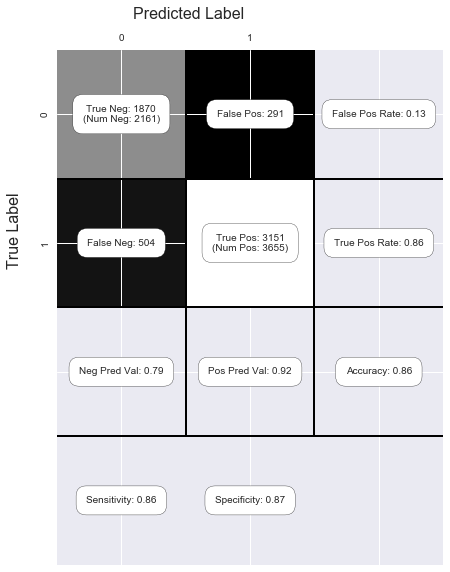

In [27]:
show_confusion_matrix(cf(y_test, prediction))